# Initialization

In [ ]:
!pip install torch
!pip install nltk
!pip install pandas
!pip install tensorflow
!pip install transformers
!pip install matplotlib
!pip install scikit-learn

In [1]:
import re
import nltk
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import tensorflow as tf
from transformers import AdamW
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
import torch.utils.data as data_utils
from transformers import AutoTokenizer
from transformers import get_scheduler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
nltk.download('stopwords')
nltk.download('punkt') 

c:\Users\ilias\Desktop\PycharmProjects\uni\aidl_cs01_nlp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ilias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!pip freeze

absl-py==1.4.0
asttokens==2.2.1
astunparse==1.6.3
backcall==0.2.0
cachetools==5.3.1
certifi==2023.5.7
charset-normalizer==3.1.0
click==8.1.4
colorama==0.4.6
comm==0.1.3
contourpy==1.1.0
cycler==0.11.0
debugpy==1.6.7
decorator==5.1.1
executing==1.2.0
filelock==3.12.2
flatbuffers==23.5.26
fonttools==4.40.0
fsspec==2023.6.0
gast==0.4.0
google-auth==2.21.0
google-auth-oauthlib==1.0.0
google-pasta==0.2.0
grpcio==1.56.0
h5py==3.9.0
huggingface-hub==0.16.2
idna==3.4
ipykernel==6.24.0
ipython==8.14.0
jedi==0.18.2
Jinja2==3.1.2
joblib==1.3.1
jupyter_client==8.3.0
jupyter_core==5.3.1
keras==2.13.1
kiwisolver==1.4.4
libclang==16.0.0
Markdown==3.4.3
MarkupSafe==2.1.3
matplotlib==3.7.2
matplotlib-inline==0.1.6
mpmath==1.3.0
nest-asyncio==1.5.6
networkx==3.1
nltk==3.8.1
numpy==1.24.3
oauthlib==3.2.2
opt-einsum==3.3.0
packaging==23.1
pandas==2.0.3
parso==0.8.3
pickleshare==0.7.5
Pillow==10.0.0
platformdirs==3.8.0
prompt-toolkit==3.0.39
protobuf==4.23.3
psutil==5.9.5
pure-eval==0.2.2
pyasn1==0.5.0
pya

In [3]:
# # setting random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
intents_to_links = {
    'Curriculum' : 'https://aidl.uniwa.gr/programme-outline/',
    'Fees': 'https://aidl.uniwa.gr/tuition-fees/',
    'Invited': 'https://aidl.uniwa.gr/invited-lecturers-2/',
    'Applications': 'https://aidl.uniwa.gr/applications/',
    'Irrelevant': 'https://aidl.uniwa.gr/',
    'Contact': 'https://aidl.uniwa.gr/contact/',
    'Schedule': 'https://aidl.uniwa.gr/course-schedule/',
    'Instructors': 'https://aidl.uniwa.gr/instructors/',
    'Documents': 'https://aidl.uniwa.gr/mscdocuments/',
    'Registry': 'https://aidl.uniwa.gr/student-registry/'
} 

In [5]:
df = pd.read_csv('input/cs01_dataset.csv')

df = df.sample(frac=1).reset_index(drop=True) 
df['label_id'] = df['Intent'].factorize()[0] 

labels = df['Intent'].unique()
label_id_to_intent = dict(enumerate(labels))

train, test = train_test_split(df, random_state=seed, test_size=0.2, shuffle=True)
x_train = train['Question']
x_test = test['Question']
y_train = train['label_id']
y_test = test['label_id'] 

# Preprocessing for LSTM

In [6]:
stop_words = stopwords.words('english')
def preprocess(text):
    text = nltk.word_tokenize(text.lower())             
    text = [w for w in text if not w in stop_words]   
    text = (" ").join(text)                             
    text = re.sub(r'[^a-z0-9A-Z_]',' ',text)         
    text = re.sub(r"\s+", r" ", text).strip()          
    return text

x_train = x_train.apply(preprocess)
x_test = x_test.apply(preprocess) 

In [7]:
n_words = 4
word_to_counts = x_train.str.split(expand=True).stack().value_counts()
word_2_index = {"SOS":0, "EOS":1, "UNK":2, "PAD":3}
index_2_word = {0: "SOS", 1: "EOS", 2:"UNK", 3:"PAD"}
most_freq_words = word_to_counts.index[:1000] 

def add_to_voc(text, word_2_index, index_2_word, most_freq_words, n_words):
  for word in text.split(' '):
    if word not in word_2_index:
      if word in most_freq_words:
        word_2_index[word] = n_words
        index_2_word[n_words] = word
        n_words += 1
      else:
        word_2_index[word] = word_2_index['UNK']
  return word_2_index, index_2_word, n_words

for i in x_train: 
  word_2_index, index_2_word, n_words = add_to_voc(i, word_2_index, index_2_word, most_freq_words,n_words)  

In [8]:
def sentence_to_int(text): 
  text = nltk.word_tokenize(text.lower())
  ints = [word_2_index['SOS']]
  for word in text:
    if word in word_2_index:
      ints.append(word_2_index[word])
    else:
      ints.append(word_2_index['UNK'])
  return ints
  
X_train = x_train.apply(sentence_to_int)
X_test = x_test.apply(sentence_to_int) 

In [9]:
max_length = int(np.mean([len(x) for x in X_train])) + 3

def remove_and_pad(text):
  length = len(text)
  if length >= max_length:
    text = text[:max_length]
    text.append(word_2_index['EOS'])
  else:
    text.append(word_2_index['EOS'])
    diff = max_length-length
    for _ in range(diff):
      text.append(word_2_index['PAD'])
  return text 
  
X_train = X_train.apply(remove_and_pad)
X_test = X_test.apply(remove_and_pad) 

In [10]:
train = np.zeros((len(x_train), 8))
for i, seq in enumerate(X_train):
  train[i,:] = seq
  
test = np.zeros((len(x_test), 8))
for i, seq in enumerate(X_test):
  test[i,:] = seq 

In [11]:
trainx = data_utils.TensorDataset(torch.from_numpy(train).to(torch.float32), torch.from_numpy(y_train.values).to(torch.float32))
train_loader = data_utils.DataLoader(trainx, batch_size=32, shuffle=True)
test_dataset = data_utils.TensorDataset(torch.from_numpy(test).to(torch.float32), torch.from_numpy(y_test.values).to(torch.float32))
test_loader = data_utils.DataLoader(test_dataset, batch_size=32, shuffle=False) 

# GloVe Init

In [12]:
# Load the pre-trained GloVe embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs  

voc = n_words
num_tokens = voc + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_2_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

# LSTM + GloVe

In [37]:
class LSTMGPU(nn.Module):                                                  
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, glove, embedding_matrix):
        super(LSTMGPU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if glove:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = False
        self.lstm1 = nn.LSTM(embedding_dim, hidden_size, 1, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, 1, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.to(device)

    def forward(self, x): 
        x = x.to(device)
        embedded = self.embedding(x.type(torch.LongTensor).to("cuda"))
        out1, (hidden1, cell1) = self.lstm1(embedded)
        out2, (hidden2, cell12) = self.lstm2(hidden1)
        out2 = self.dropout(out2.contiguous().view(-1, self.hidden_size) )
        output = self.fc(out2.contiguous().view(-1, self.hidden_size) )
        return output

In [38]:
def my_func(n_wor, emb_dim, hid_size, num_lay, num_class, glv, emb_matrix):
    model = LSTMGPU(n_wor, emb_dim, hid_size, num_lay, num_class, glv, emb_matrix)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
    num_training_steps = 100 * len(train_loader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # Train the model
    losses = []
    model.train()
    n_total_steps = len(train_loader)
    for epoch in range(100):
        for i, (inputs, labels) in enumerate(train_loader):  
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
            if (i+1) % 6 == 0:
                #print (f'Epoch [{epoch+1}/{30}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}', end="")
                print('\rEpoch [{}/{}]\t, Step: [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, i+1, n_total_steps, loss.item()), end="")

            # Save the loss
            losses.append(loss.item())
    
    return model

In [39]:
model_LSTM = my_func(n_words, 100, 64, 4, 10, 0, None) 

Epoch [100/100]	, Step: [108/113], Loss: 0.0018

In [16]:
model_LSTM_GloVe = my_func(n_words, 100, 64, 4, 10, 1, embedding_matrix) 

Epoch [100/100]	, Step: [108/113], Loss: 0.0059

In [17]:
# F1 score
# Evaluate the model on the test data
y_true = []
y_pred = []
model_LSTM.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_LSTM(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
f1 = f1_score(y_true, y_pred, average='macro')
print(' Test F1 Score: {:.4f}'.format(f1))

 Test F1 Score: 0.8054


In [18]:
# F1 score
# Evaluate the model on the test data
y_true = []
y_pred = []
model_LSTM_GloVe.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_LSTM_GloVe(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
f1 = f1_score(y_true, y_pred, average='macro')
print(' Test F1 Score: {:.4f}'.format(f1))

 Test F1 Score: 0.7945


# Transformers

In [19]:
checkpoint = "albert-base-v2"
# checkpoint = "roberta-base"
# checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# encoding data to input format for BERT
def encode(sentence):
    return tokenizer.encode(sentence, add_special_tokens=True,padding='max_length', max_length=20, truncation=True)

train_encoded = [encode(s) for s in x_train.values]
train_inputs = torch.tensor(train_encoded)
train_labels = torch.tensor(y_train.values)
train_dataset = TensorDataset(train_inputs, train_labels)

test_encoded = [encode(s) for s in x_test.values]
test_inputs = torch.tensor(test_encoded)
test_labels = torch.tensor(y_test.values)
test_dataset = TensorDataset(test_inputs, test_labels)

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=10)
model = model.to(device) 

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

In [21]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
optimizer = AdamW(model.parameters(), lr=0.00001)
num_epochs = 100

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
criterion = nn.CrossEntropyLoss()
model.train()
losses = []
n_total_steps = len(train_dataloader)
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels.long())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        if (i+1) % 6 == 0:
            print('\rEpoch [{}/{}]\t, Step: [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, i+1, n_total_steps, loss.item()), end="")
        
        # Save the loss
        losses.append(loss.item())

c:\Users\Effy\PycharmProjects\uni\aidl_cs01_nlp\.venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [100/100]	, Step: [222/225], Loss: 0.0005

In [23]:
# F1 score
# Evaluate the model on the test data
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
f1 = f1_score(y_true, y_pred, average='macro')
print(' Test F1 Score: {:.4f}'.format(f1))

 Test F1 Score: 0.8356


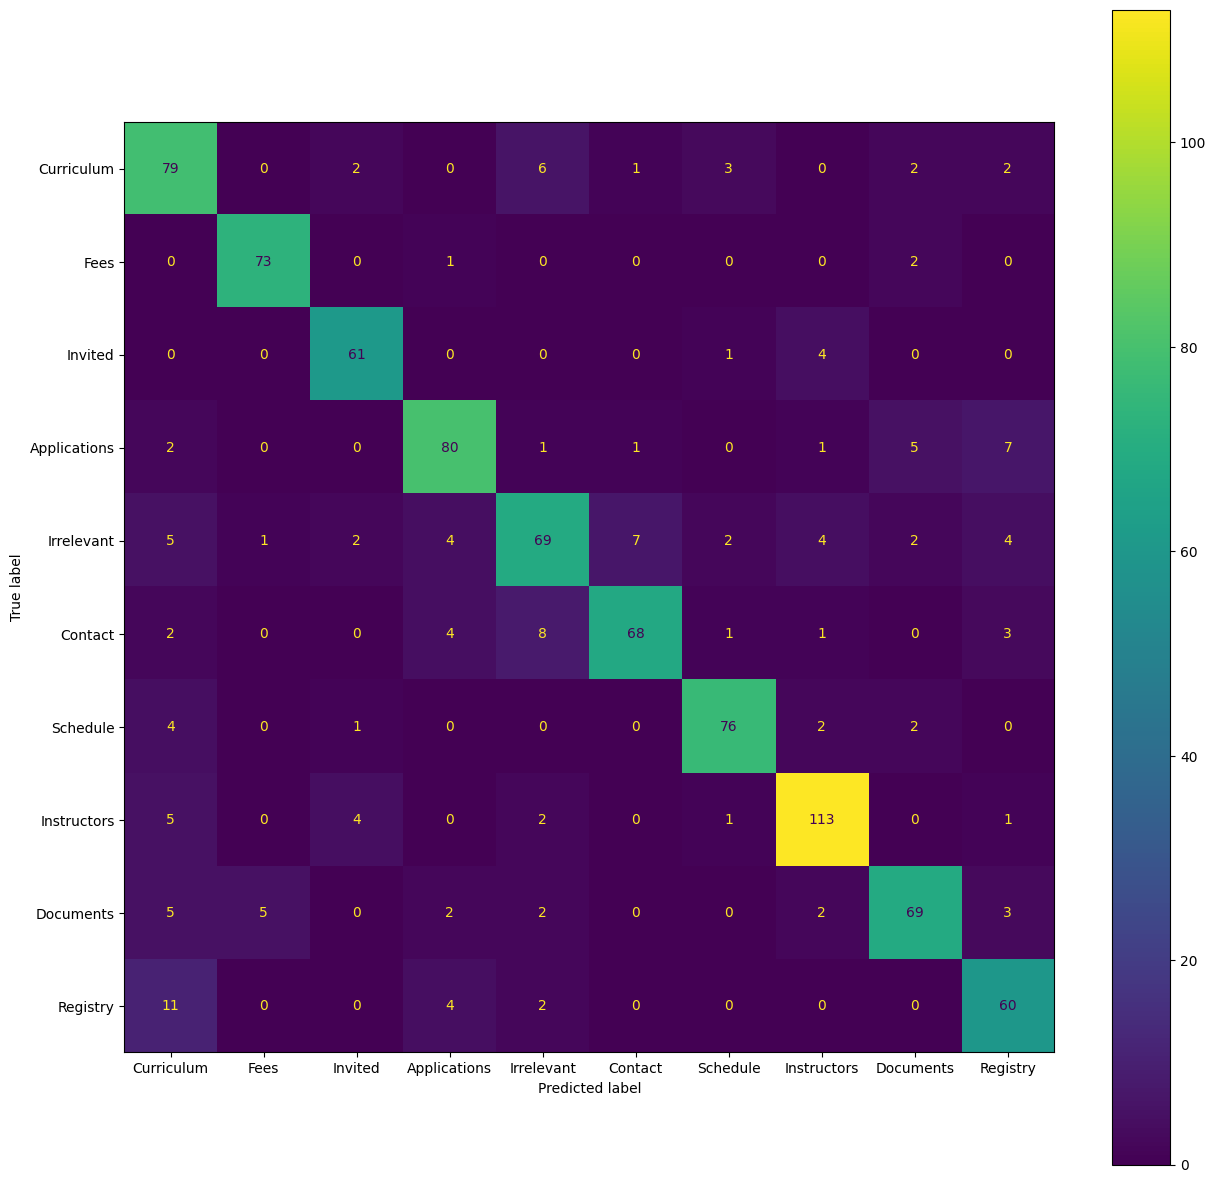

In [24]:
class_names = list(label_id_to_intent.values())
cm = confusion_matrix(y_true = y_true, y_pred = y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.show()

# Helper Functions for Answers

In [44]:
def get_answer_from_LSTM(my_quest, my_model):
    my_question = pd.Series([my_quest]) 
    stop_words = stopwords.words('english')
    def preprocess(text):
        text = nltk.word_tokenize(text.lower())            
        text = [w for w in text if not w in stop_words]     
        text = (" ").join(text)                             
        text = re.sub(r'[^a-z0-9A-Z_]',' ',text)           
        text = re.sub(r"\s+", r" ", text).strip()          
        return text

    def sentence_to_int(text): 
        text = nltk.word_tokenize(text.lower())
        ints = [word_2_index['SOS']]
        for word in text:
            if word in word_2_index:
                ints.append(word_2_index[word])
            else:
                ints.append(word_2_index['UNK'])
        return ints

    def remove_and_pad(text):
        length = len(text)
        if length >= 7:
            text = text[:7]
            text.append(word_2_index['EOS'])
        else:
            text.append(word_2_index['EOS'])
            diff = 7-length
            for _ in range(diff):
                text.append(word_2_index['PAD'])
        return text 
        
    my_question = my_question.apply(preprocess)
    my_question = my_question.apply(sentence_to_int)
    my_question = my_question.apply(remove_and_pad)
    my_model.eval()
    with torch.no_grad():
        train = np.zeros((1, 8))
        train[0,:] = my_question[0]
        input = torch.from_numpy(train).to(torch.float32)
        print(input)
        print(input.size())
        print(input.reshape(1,-1))
        print(input.reshape(1,-1).size())
        outputs = my_model(input.reshape(1,-1))
        _, predicted = torch.max(outputs, 1)
        answer = label_id_to_intent[predicted.item()]
        print(answer)
        answer = intents_to_links[answer]
    return answer 

In [45]:
def get_answer_transformers(my_question, mod):
    my_question = encode(my_question)
    mod.eval()
    with torch.no_grad():
        train = np.zeros((1, 20))
        train[0,:] = my_question
        input = torch.from_numpy(train).to(torch.float32)
        input = input.to(device)
        outputs = mod(input.long())
        _, predicted = torch.max(outputs.logits, 1)
        answer = label_id_to_intent[predicted.item()]
        print(answer)
        answer = intents_to_links[answer]
    return answer 

# Get Answers From Models

In [46]:
get_answer_from_LSTM('Where can I find courses', model_LSTM) 

tensor([[ 0., 52., 20.,  1.,  3.,  3.,  3.,  3.]])
torch.Size([1, 8])
tensor([[ 0., 52., 20.,  1.,  3.,  3.,  3.,  3.]])
torch.Size([1, 8])
Registry


'https://aidl.uniwa.gr/student-registry/'

In [28]:
get_answer_transformers('Where can I find courses', model) 

Registry


'https://aidl.uniwa.gr/student-registry/'

In [29]:
get_answer_transformers('c o u r s e', model) 

Irrelevant


'https://aidl.uniwa.gr/'